In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

In [2]:
import numpy as np
import random
import torch
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable
import torchio as tio
from models.segmentation import *    # DiceLoss, GeneralizedDiceLoss, VNet
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time
import gc
import wandb

In [3]:
plt.rcParams['figure.figsize'] = 12, 6

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)

Last run on Sat Mar 25 16:50:16 2023
TorchIO version: 0.18.83


In [4]:
RANDOM_SEED = 551

In [5]:
# control randomness
def set_seed(random_seed=551):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)

In [6]:
def prepare_dataset(image_dir='./input_nifti_crop/', label_dir='./seg_nifti_crop/'):
        # img_list = list(map(lambda path: img_dir + path, os.listdir(img_dir)))
    filenames = os.listdir(label_dir)  # image_dir랑 label_dir에 저장되어있는 파일명이 같음

    subjects = []
    for filename in tqdm(filenames):
        subject = tio.Subject(
            img = tio.ScalarImage(image_dir + filename),
            label = tio.LabelMap(label_dir + filename))   # label => LabelMap!!!!!!!
        subjects.append(subject)
    dataset = tio.SubjectsDataset(subjects)
    return subjects, dataset

In [7]:
def run_training(net_seg):
    running_seg_loss = 0.0

    for i, data in enumerate(tqdm(train_loader, 0)):
        inputs, labels = data['img']['data'], data['label']['data']

#         print('before')
#         plt.imshow(labels[0,0,:,:,labels.shape[4]//2])
#         plt.show()

        
#         print('labels:', labels[0,0,:,:,labels.shape[4]//2])
        
#         l1=(labels==1)
#         l0=(labels==0)
#         labels = torch.cat((l0,l1),1)
        
#         print('after')
#         plt.imshow(labels[0,0,:,:,labels.shape[4]//2])
#         plt.show()
#         plt.imshow(labels[0,1,:,:,labels.shape[4]//2])
#         plt.show()
#         break

        if torch.cuda.is_available:
            inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

        inputs, labels = Variable(inputs), Variable(labels)
#         if (i % effective_batchsize) == 0:
        optimizer_seg.zero_grad()
        
        net_seg.train()
        outputs_seg = net_seg(inputs)

        outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
#         ##
#         print('input:',outputs_seg.shape,'target:', labels.shape)
        loss_seg = criterion_seg(outputs_seg, labels)

        loss_seg.backward()
        optimizer_seg.step()

        running_seg_loss += loss_seg.detach().cpu().item()
        gc.collect()
        torch.cuda.empty_cache()
    
    avg_loss = running_seg_loss / len(train_loader)
    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]
    one_output_lbl = labels.detach().cpu().numpy()[0]
    
    return avg_loss, one_output_seg, one_output_img, one_output_lbl

In [8]:
def run_validation(net_seg):
    net_seg.eval()
  
    running_seg_loss = 0.0
    total_output_seg=[]
    total_output_img=[]
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(valid_loader, 0)):
            inputs, labels = data['img']['data'], data['label']['data']    
            
#             l1=(labels==1)
#             l0=(labels==0)
#             labels = torch.cat((l0,l1),1)
            
            if torch.cuda.is_available:
                inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

            inputs, labels = Variable(inputs), Variable(labels)
            
            net_seg.eval()
            
            total_inputs=copy.deepcopy(inputs)
            total_output_img.append(total_inputs.detach().cpu().numpy())
            
            outputs_seg = net_seg(inputs)
            outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
            total_outputs=copy.deepcopy(outputs_seg)
            total_output_seg.append(total_outputs.detach().cpu().numpy())
            
            loss_seg = criterion_seg(outputs_seg, labels)
            running_seg_loss += loss_seg.detach().cpu().item()
    avg_loss = running_seg_loss / len(valid_loader)
    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]

    one_output_lbl = labels.detach().cpu().numpy()[0]
    #total_output_img=np.reshape(1,224,224,32)
    #total_output_seg=np.reshape(1,224,224,32)

    return avg_loss, one_output_seg, one_output_img, one_output_lbl, total_output_seg, total_output_img

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print('Device:', device)
#print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Count of using GPUs: 2


In [10]:
image_dir = './input_nifti_300/'  #'./input_nifti/'
label_dir = './seg_nifti_300/'  #'./input_nifti_seg/'
subjects, dataset = prepare_dataset(image_dir, label_dir)

100%|██████████████████████████████████████| 115/115 [00:00<00:00, 21952.71it/s]


In [11]:
print('Dataset size : ', len(dataset), 'subjects')

Dataset size :  115 subjects


In [12]:
set_seed()

split_rate = 0.8
_, _, _, d = dataset[0].shape
w, h = 300, 300
# img_size = 112  # [16,32,48,64,80,96,112,128,144,160]
# 200 => 112를 만들려면? 88을 빼야 함

# transformation
train_transform = tio.Compose([
    tio.Resample(1.5),
    tio.Crop((44,44,44,44,54,34)),
#     tio.Clamp(480,720),
    tio.ZNormalization(),
#     tio.OneHot(),
])

valid_transform = tio.Compose([
    tio.Resample(1.5),
    tio.Crop((44,44,44,44,54,34)),
#     tio.Clamp(480,720),
    tio.ZNormalization(),
#     tio.OneHot(),
])

# data split
set_seed()
num_subjects = len(dataset)
num_train_subjects = int(split_rate * num_subjects)
num_valid_subjects = num_subjects - num_train_subjects
num_split_subjects = num_train_subjects, num_valid_subjects
train_subjects, valid_subjects = random_split(subjects, num_split_subjects)

# training set
train_set = tio.SubjectsDataset(
    train_subjects, transform=train_transform)
# validation set
valid_set = tio.SubjectsDataset(
    valid_subjects, transform=valid_transform)

print('Training set:', len(train_set), 'subjects')
print('Validation set:', len(valid_set), 'subjects')

Training set: 92 subjects
Validation set: 23 subjects


In [13]:
# without patch sampling
batch_size = 16
valid_batch_size = 16

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)
valid_loader = DataLoader(valid_set, batch_size=valid_batch_size, num_workers=16)

---

### 데이터셋 확인

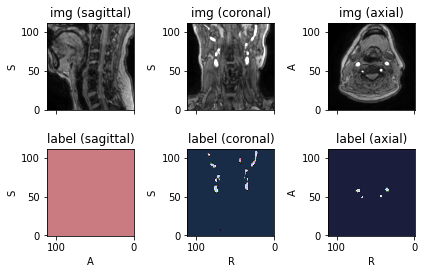

In [14]:
training_instance = train_set[11]  # transform is applied inside SubjectsDataset
training_instance.plot()

(1, 112, 112, 112) (1, 112, 112, 112)


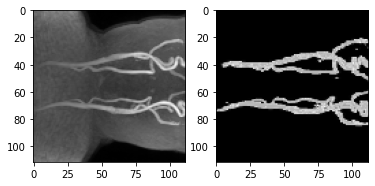

In [15]:
# check image contrast
data = training_instance['img'].data.detach().numpy()
data_label = training_instance['label'].data.detach().numpy()
print(data.shape, data_label.shape)

img_size = data.shape[1]

plt.subplot(1,2,1)
plt.imshow(np.max(data.squeeze(), axis=1), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(np.max(data_label.squeeze(), axis=1), cmap='gray')
plt.show()

In [16]:
# check data size
print('shape : ',training_instance['img'].shape, training_instance['label'].shape)
# check value
shape = training_instance['label'].shape
print(training_instance['img'].data[0,shape[1]//2,:,shape[3]//2])
print(training_instance['label'].data[0,shape[1]//2,:,shape[3]//2])

shape :  (1, 112, 112, 112) (1, 112, 112, 112)
tensor([-0.9124, -0.8880, -0.9006, -0.8952, -0.8981, -0.8893, -0.8951, -0.8443,
        -0.6310,  0.0747,  0.1482, -0.1827,  0.7326,  1.2490,  1.1565,  1.0848,
         1.1453,  1.5750,  1.1837,  0.6961, -0.1258,  0.3549,  0.4859,  0.0525,
        -0.2126,  0.0058, -0.0470,  0.3795,  0.6799,  0.4596,  0.4080,  0.6265,
         0.2938,  0.2935,  0.3689,  0.5933, -0.2635, -0.5601, -0.6486,  0.0561,
         0.4078,  0.4374,  0.7669,  0.7345,  0.6414,  0.5288, -0.0752, -0.4952,
        -0.3612, -0.2655, -0.3195, -0.3610, -0.2075, -0.1917, -0.2467, -0.2857,
        -0.4215, -0.5884,  0.3628,  0.4066, -0.0187, -0.3606, -0.6528, -0.7381,
        -0.7260, -0.5540, -0.6952, -0.5675, -0.0975,  0.1862,  0.2894,  0.0091,
        -0.1931, -0.4630,  0.0647,  0.3146,  0.0422,  0.5414,  0.6841,  0.3807,
        -0.6589, -0.2263,  0.7489,  0.9459,  1.4608,  1.2054,  0.8547,  1.2906,
         1.0891,  0.9835,  1.1814,  1.0395,  0.9630,  1.2335,  1.4047,  0

In [17]:
## test
normalization = 'groupnorm'
net_seg = VNet(n_channels=1, n_classes=2, n_filters=16, normalization=normalization)
net_seg

VNet(
  (block_one): ResidualConvBlock(
    (conv): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm3D()
      (2): ReLU(inplace=True)
    )
  )
  (block_one_dw): DownsamplingConvBlock(
    (conv): Sequential(
      (0): Conv3d(16, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2))
      (1): GroupNorm3D()
      (2): ReLU(inplace=True)
    )
  )
  (block_two): ResidualConvBlock(
    (conv): Sequential(
      (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm3D()
      (2): ReLU(inplace=True)
      (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): GroupNorm3D()
      (5): ReLU(inplace=True)
    )
  )
  (block_two_dw): DownsamplingConvBlock(
    (conv): Sequential(
      (0): Conv3d(32, 64, kernel_size=(2, 2, 2), stride=(2, 2, 2))
      (1): GroupNorm3D()
      (2): ReLU(inplace=True)
    )
  )
  (block_three): ResidualConvBlock(
    (c

---

In [18]:
normalization = 'groupnorm'
num_epochs = 40
lr = 0.001
optim_class = optim.Adam

In [ ]:
set_seed()
net_seg = VNet(n_channels=1, n_classes=2, n_filters=16, normalization=normalization)  # num classes: 2 (background, label)
net_seg = torch.nn.DataParallel(net_seg, device_ids=[0, 1])
net_seg.cuda()

wandb.init(
    project='202303-segmentation',
    config={"model": "VNet", "input_size": img_size,
            "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
            "cost_function": "DiceLoss", "optimizer": optim_class.__name__})
wandb.watch(net_seg)

train_losses = []
validation_losses = []
# S = 8

optimizer_seg = optim_class(net_seg.parameters(), lr=lr)
criterion_seg = DiceLoss()
# criterion_seg = GeneralizedDiceLoss()
# scheduler = optim.lr_scheduler.StepLR(optimizer_seg, step_size=20, gamma=0.1)

set_seed()
for epoch in range(num_epochs):
    train_loss, train_seg_part, train_img_part, train_input_lbl = run_training(net_seg)
    valid_loss, valid_output_seg_part, valid_input_img_part, valid_input_lbl_part, valid_total_seg, valid_total_img = run_validation(net_seg)
    print('# EPOCH %d / %d'%(epoch+1, num_epochs))
    train_losses.append(train_loss)
    validation_losses.append(valid_loss)
    
    train_img = wandb.Image(np.max(train_img_part[0].squeeze(), axis=1))
    train_truth = wandb.Image(np.max(train_input_lbl[0].squeeze(), axis=1), caption="Ground truth")
    train_pred = wandb.Image(np.max(train_seg_part[0].squeeze(), axis=1), caption="Prediction")
    valid_img = wandb.Image(np.max(valid_input_img_part[0].squeeze(), axis=1))
    valid_truth = wandb.Image(np.max(valid_input_lbl_part[0].squeeze(), axis=1), caption="Ground truth")
    valid_pred = wandb.Image(np.max(valid_output_seg_part[0].squeeze(), axis=1), caption="Prediction")
    
#     lbl_train = train_input_lbl[0, :, : ,S]
#     seg_train = train_seg_part[0, :, : , S]
#     lbl_valid = valid_input_lbl_part[0, :, : , S]
#     seg_valid = valid_output_seg_part[0, :, : , S]
    
        
#     if i%5==0:
#         print('Train')
# #         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S],train_input_lbl[1, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#         plt.show()
# #         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S],train_seg_part[1, :, : ,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#         plt.show()
        
#         print('Valid')
# #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S],valid_input_lbl_part[1, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#         plt.show()  
# #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S],valid_output_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#         plt.show()
        
#         # loss curve
#         plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
#         red_patch = mpatches.Patch(color='red', label='Validation')
#         blue_patch = mpatches.Patch(color='blue', label='Training')
#         plt.legend(handles=[red_patch, blue_patch])
#         plt.show()
        

    wandb.log({"train_loss": train_loss, "valid_loss": valid_loss,
               "train_img": train_img, "valid_img": valid_img,
               "train_label": train_truth, "train_pred": train_pred,
               "valid_label": valid_truth, "valid_pred": valid_pred})
wandb.finish()
torch.save(net_seg.state_dict(), 'pretrained/seg_230325_original-img_{}'.format(img_size))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 27.00s/it]


# EPOCH 1 / 40


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.98s/it]


# EPOCH 2 / 40


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.22s/it]


# EPOCH 3 / 40


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.84s/it]


# EPOCH 4 / 40


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.52s/it]


# EPOCH 5 / 40


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.60s/it]


# EPOCH 6 / 40


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.91s/it]


# EPOCH 7 / 40


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.23s/it]


# EPOCH 8 / 40


  0%|                                                     | 0/2 [00:00<?, ?it/s]

In [ ]:
#(2.1.1) - random seed=551, gc.collect(activate), batch size=16
train_losses = []
validation_losses = []
S = 60
save_path = '/home/minyoung/SEGMENTATION/23.02.22/model_backup/02.24(2.1.1)'
start_time = time.time()


print('STARTING TRAINING')

for i in range(num_epochs):
    train_loss, train_seg_part, train_img_part, train_input_lbl = run_training(net_seg)
    valid_loss, valid_output_seg_part, valid_input_img_part, valid_input_lbl_part, valid_total_seg, valid_total_img = run_validation(net_seg)
    print('EPOCH {} of {}'.format(i, num_epochs))
    print('-- train loss {} -- valid loss {} --'.format(train_loss, valid_loss))
    print('-----run time {}sec -----'.format(time.time()-start_time))
    train_losses.append(train_loss)
    validation_losses.append(valid_loss)
    
        
    if i%5==0:
        
        print('Train')
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S],
                                              train_input_lbl[1,:,:,S],train_input_lbl[2,:,:,S],
                                              train_input_lbl[3,:,:,S],train_input_lbl[4,:,:,S],train_input_lbl[5,:,:,S],
                                             train_input_lbl[6,:,:,S],train_input_lbl[7,:,:,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.show()
        
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S],
                                              train_seg_part[1,:,:,S],train_seg_part[2,:,:,S],
                                              train_seg_part[3,:,:,S],train_seg_part[4,:,:,S],train_seg_part[5,:,:,S],
                                             train_seg_part[6,:,:,S],train_seg_part[7,:,:,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.show()
        
        print('Valid')
        plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S],
                                              valid_input_lbl_part[1,:,:,S],valid_input_lbl_part[2,:,:,S],
                                              valid_input_lbl_part[3,:,:,S],valid_input_lbl_part[4,:,:,S],valid_input_lbl_part[5,:,:,S],
                                             valid_input_lbl_part[6,:,:,S],valid_input_lbl_part[7,:,:,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.show()  
        plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S],
                                              valid_output_seg_part[1,:,:,S],valid_output_seg_part[2,:,:,S],
                                              valid_output_seg_part[3,:,:,S],valid_output_seg_part[4,:,:,S],valid_output_seg_part[5,:,:,S],
                                             valid_output_seg_part[6,:,:,S],valid_output_seg_part[7,:,:,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        
        plt.show()
        
        plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
        red_patch = mpatches.Patch(color='red', label='Validation')
        blue_patch = mpatches.Patch(color='blue', label='Training')
        plt.legend(handles=[red_patch, blue_patch])
        plt.show()
        
        #torch.save(net_seg,'vnet_ct_training_epoch='+str(i))
    path = os.path.join(save_path, 'vnet_epoch='+str(i))
    torch.save(net_seg,path)

STARTING TRAINING
EPOCH 0 of 80
-- train loss 0.8596555168981905 -- valid loss 0.7948034370646757 --
-----run time 1114.8109142780304sec -----
Train


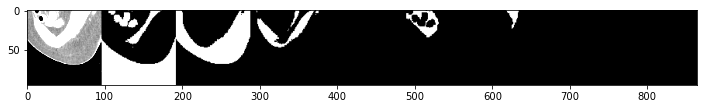

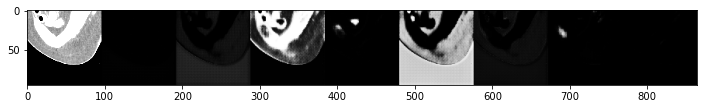

Valid


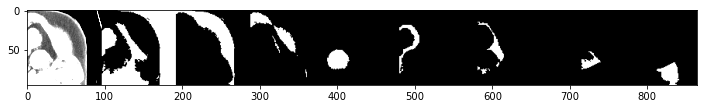

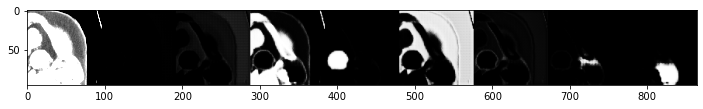

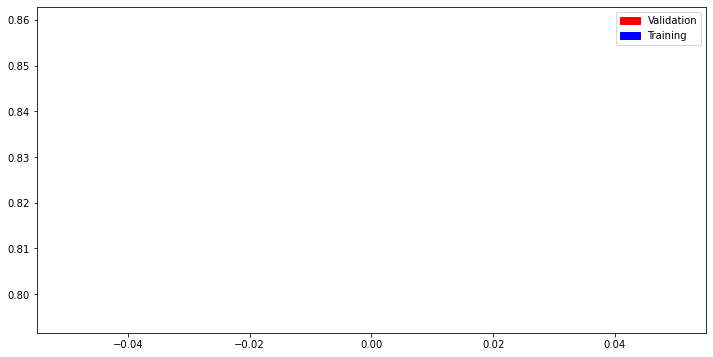

EPOCH 1 of 80
-- train loss 0.7451858262221018 -- valid loss 0.7165709234335843 --
-----run time 2208.168706178665sec -----
EPOCH 2 of 80
-- train loss 0.6956642704981345 -- valid loss 0.670867796329891 --
-----run time 3340.2041285037994sec -----
EPOCH 3 of 80
-- train loss 0.6784807549582588 -- valid loss 0.6632975129520192 --
-----run time 4490.242100477219sec -----
EPOCH 4 of 80
-- train loss 0.6707160472869873 -- valid loss 0.6578991018673953 --
-----run time 5671.902773141861sec -----
EPOCH 5 of 80
-- train loss 0.6660156585552074 -- valid loss 0.6567241444307215 --
-----run time 6808.93154501915sec -----
Train


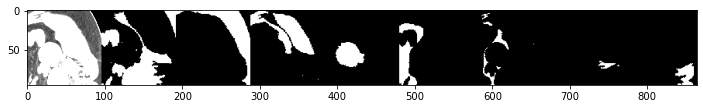

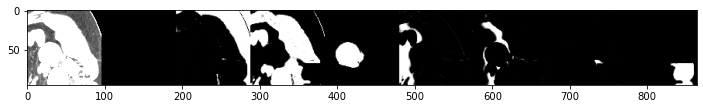

Valid


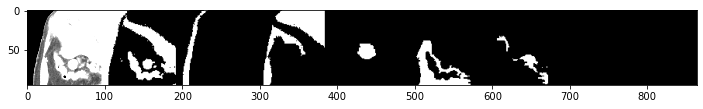

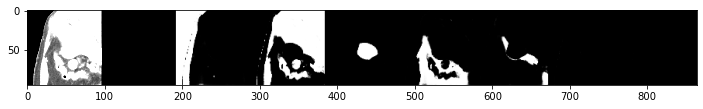

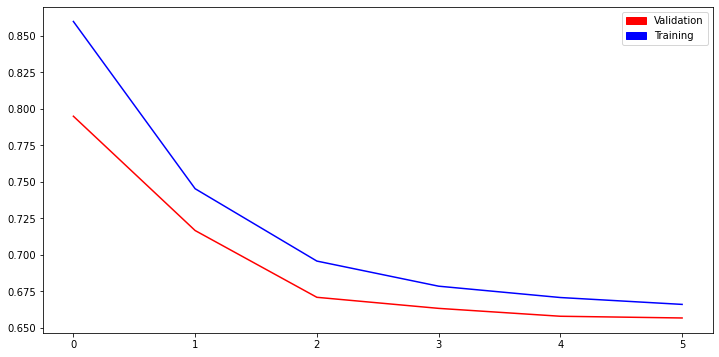

EPOCH 6 of 80
-- train loss 0.658608266821614 -- valid loss 0.6560753601438859 --
-----run time 8090.48868894577sec -----
EPOCH 7 of 80
-- train loss 0.6604924062887828 -- valid loss 0.6479278645094704 --
-----run time 9201.27084183693sec -----
EPOCH 8 of 80
-- train loss 0.6561016427146064 -- valid loss 0.6518825730856728 --
-----run time 10244.703503847122sec -----
EPOCH 9 of 80
-- train loss 0.6487123154931598 -- valid loss 0.6403067409992218 --
-----run time 11432.080772161484sec -----
EPOCH 10 of 80
-- train loss 0.6525038619836171 -- valid loss 0.6426005004083409 --
-----run time 12442.208837985992sec -----
Train


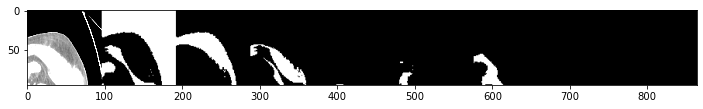

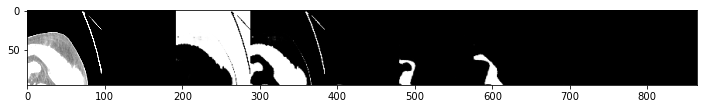

Valid


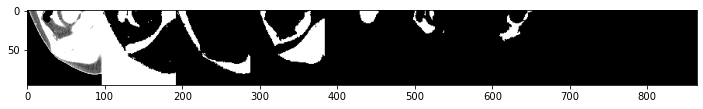

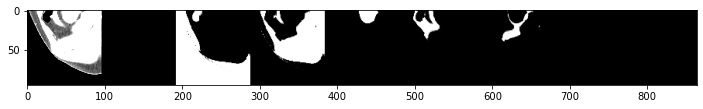

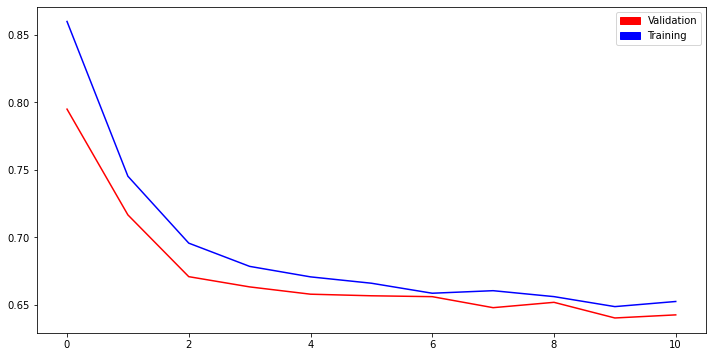

EPOCH 11 of 80
-- train loss 0.6469838046365314 -- valid loss 0.6440446070011925 --
-----run time 13565.973823547363sec -----
EPOCH 12 of 80
-- train loss 0.6482607077669215 -- valid loss 0.6469175789286109 --
-----run time 14726.861162424088sec -----
EPOCH 13 of 80
-- train loss 0.6495492908689711 -- valid loss 0.6344808094641742 --
-----run time 15813.07770395279sec -----
EPOCH 14 of 80
-- train loss 0.6425372034311294 -- valid loss 0.6424774772980634 --
-----run time 16946.018802165985sec -----
EPOCH 15 of 80
-- train loss 0.6463103564801039 -- valid loss 0.6438237402368995 --
-----run time 18102.780728578568sec -----
Train


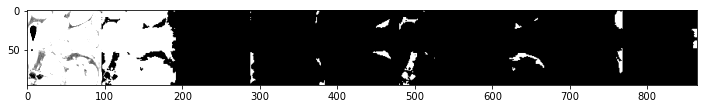

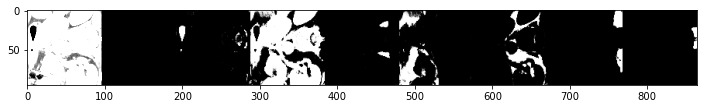

Valid


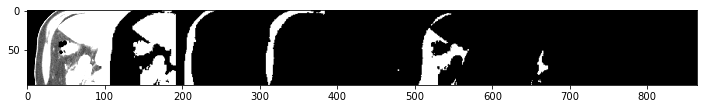

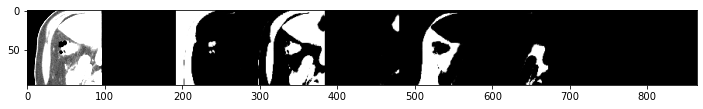

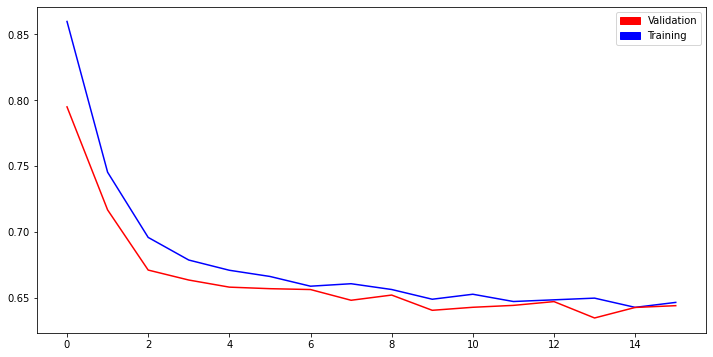

EPOCH 16 of 80
-- train loss 0.6467566355510994 -- valid loss 0.6400469059453291 --
-----run time 19228.69872736931sec -----
EPOCH 17 of 80
-- train loss 0.6464372173503593 -- valid loss 0.6450555473566055 --
-----run time 20354.090183019638sec -----
EPOCH 18 of 80
-- train loss 0.6409321197757014 -- valid loss 0.6406154334545135 --
-----run time 21419.684512615204sec -----
EPOCH 19 of 80
-- train loss 0.6425303974637279 -- valid loss 0.6315890936290517 --
-----run time 22496.58354306221sec -----
EPOCH 20 of 80
-- train loss 0.6370535553605469 -- valid loss 0.6329748367562014 --
-----run time 23639.78410243988sec -----
Train


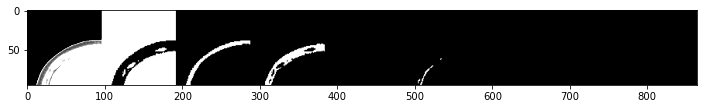

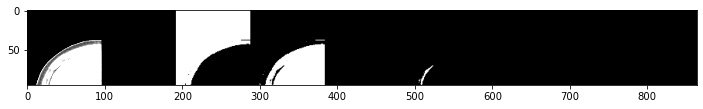

Valid


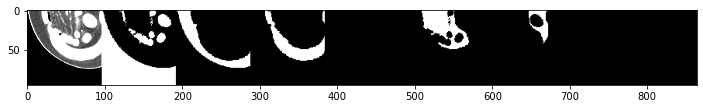

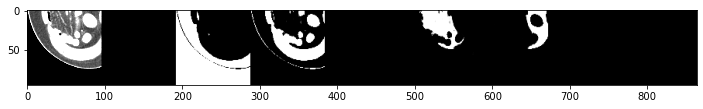

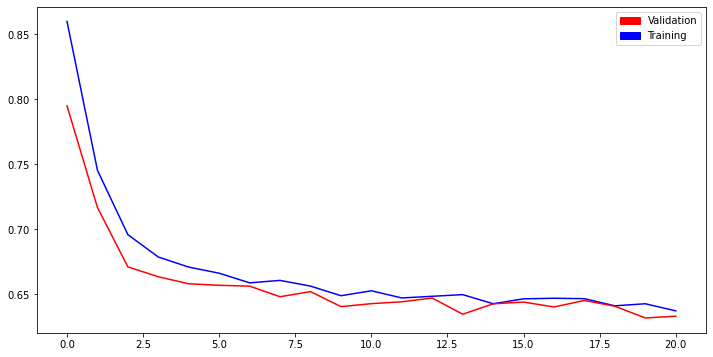

EPOCH 21 of 80
-- train loss 0.6320713141450176 -- valid loss 0.6333339836667565 --
-----run time 24675.21617412567sec -----
EPOCH 22 of 80
-- train loss 0.6330781487403092 -- valid loss 0.631299557054744 --
-----run time 25710.189348459244sec -----
EPOCH 23 of 80
-- train loss 0.6372815288879253 -- valid loss 0.6313556669389501 --
-----run time 26866.180634260178sec -----
EPOCH 24 of 80
-- train loss 0.6352387028711813 -- valid loss 0.6333498104530222 --
-----run time 27990.966165304184sec -----
EPOCH 25 of 80
-- train loss 0.6347475093823892 -- valid loss 0.6269497380537146 --
-----run time 29056.236058473587sec -----
Train


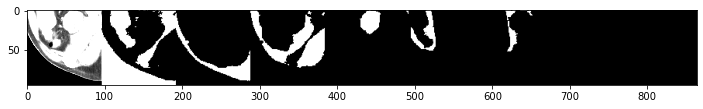

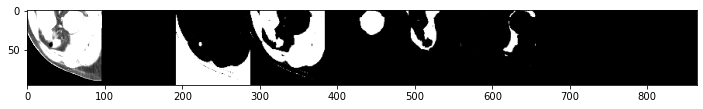

Valid


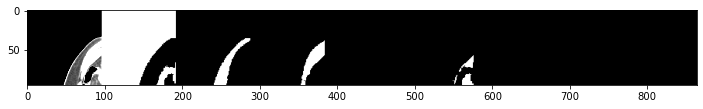

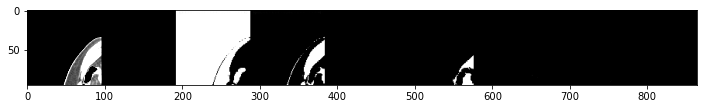

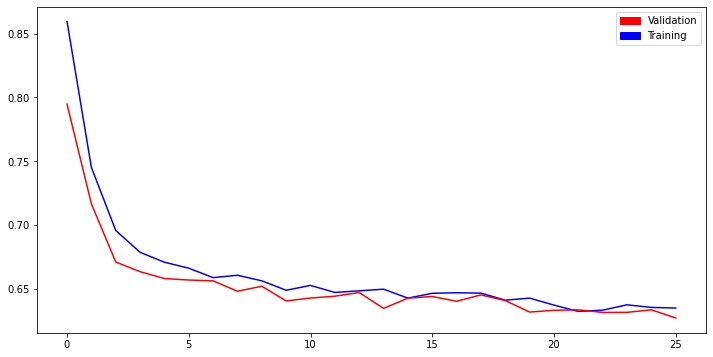

EPOCH 26 of 80
-- train loss 0.6350931702940552 -- valid loss 0.6324604197460062 --
-----run time 30158.785637378693sec -----
EPOCH 27 of 80
-- train loss 0.6349908524089389 -- valid loss 0.6318755062187419 --
-----run time 31278.104822158813sec -----
EPOCH 28 of 80
-- train loss 0.6345424364010493 -- valid loss 0.6332401151166243 --
-----run time 32532.603448867798sec -----
EPOCH 29 of 80
-- train loss 0.6396411539227874 -- valid loss 0.6316288744702059 --
-----run time 33669.77456617355sec -----
EPOCH 30 of 80
-- train loss 0.6341844714350171 -- valid loss 0.6241549744325525 --
-----run time 34851.72907447815sec -----
Train


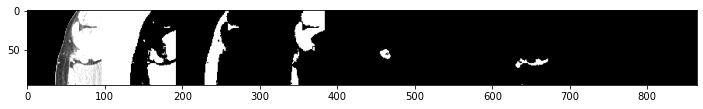

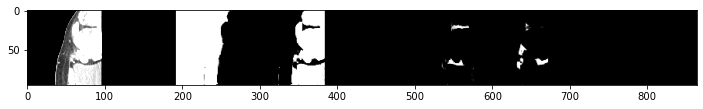

Valid


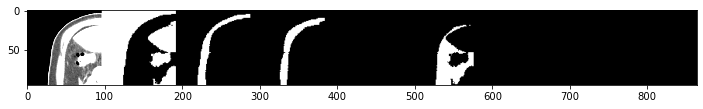

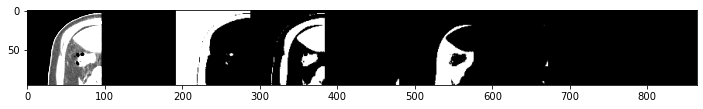

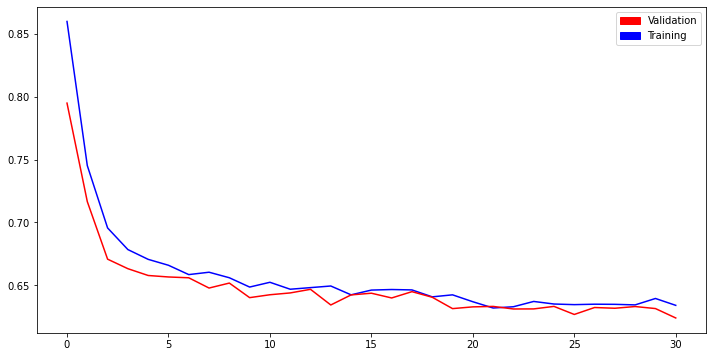

EPOCH 31 of 80
-- train loss 0.6337772476452368 -- valid loss 0.6325888554839527 --
-----run time 36015.24199271202sec -----
EPOCH 32 of 80
-- train loss 0.6344479556436892 -- valid loss 0.6286819691167158 --
-----run time 37104.82044816017sec -----
EPOCH 33 of 80
-- train loss 0.6350177605946858 -- valid loss 0.6277120310594054 --
-----run time 38257.14905667305sec -----
EPOCH 34 of 80
-- train loss 0.6319592003469114 -- valid loss 0.634308385060114 --
-----run time 39480.34444332123sec -----
EPOCH 35 of 80
-- train loss 0.6349094582928552 -- valid loss 0.633056702420992 --
-----run time 40538.97672200203sec -----
Train


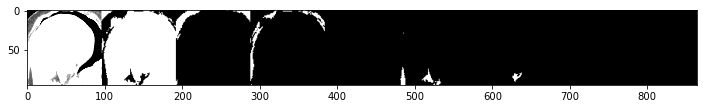

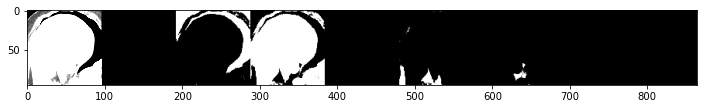

Valid


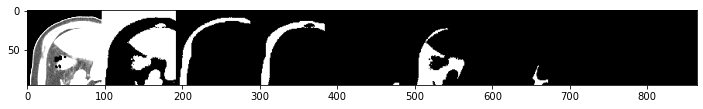

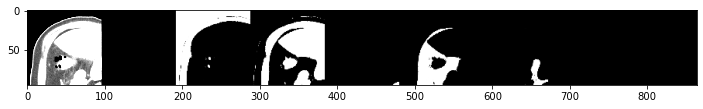

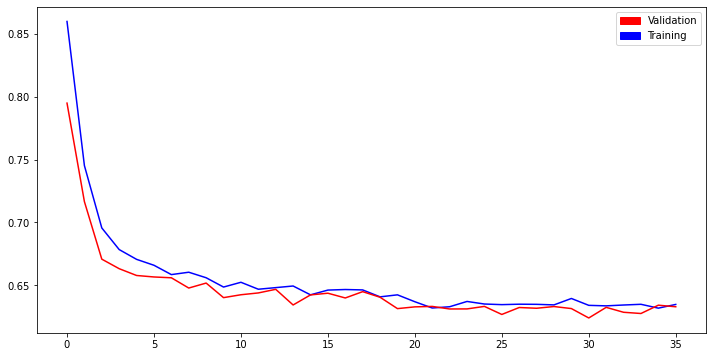

EPOCH 36 of 80
-- train loss 0.6318273184476075 -- valid loss 0.6321245813194443 --
-----run time 41651.06511902809sec -----
EPOCH 37 of 80
-- train loss 0.6358682761589686 -- valid loss 0.6385325912167045 --
-----run time 42693.959798812866sec -----
EPOCH 38 of 80
-- train loss 0.6371629807684157 -- valid loss 0.6332376857890802 --
-----run time 43780.21350502968sec -----
EPOCH 39 of 80
-- train loss 0.6320784031241028 -- valid loss 0.6327723330434631 --
-----run time 44911.018350601196sec -----
EPOCH 40 of 80
-- train loss 0.6366126280139994 -- valid loss 0.6361608663026024 --
-----run time 46074.690722465515sec -----
Train


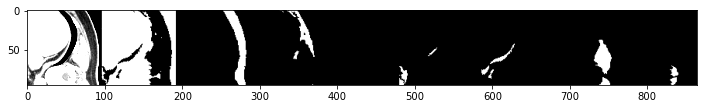

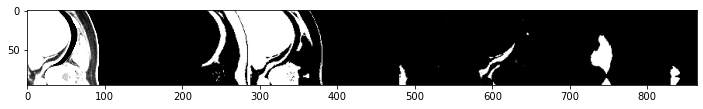

Valid


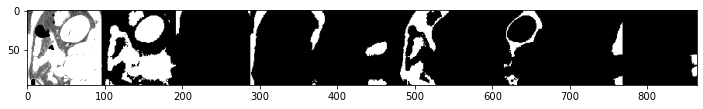

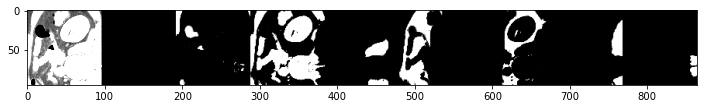

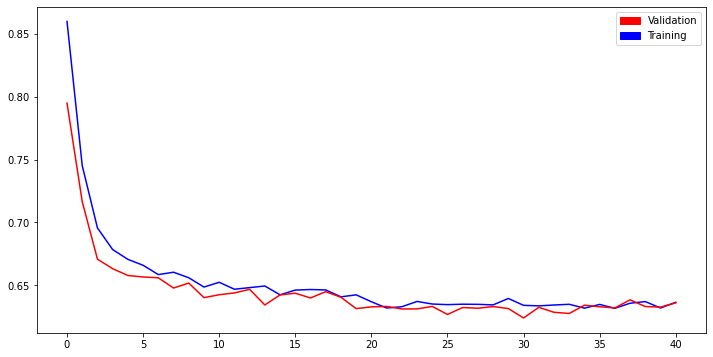

EPOCH 41 of 80
-- train loss 0.6345743006026303 -- valid loss 0.6188154764035169 --
-----run time 47141.708929777145sec -----
EPOCH 42 of 80
-- train loss 0.6282357818550534 -- valid loss 0.6246015201596653 --
-----run time 48307.55133652687sec -----
EPOCH 43 of 80
-- train loss 0.6343669620928941 -- valid loss 0.6287056970245698 --
-----run time 49437.779465675354sec -----
EPOCH 44 of 80
-- train loss 0.6277359062874759 -- valid loss 0.6323332830387003 --
-----run time 50508.46399450302sec -----
EPOCH 45 of 80
-- train loss 0.6287645161151886 -- valid loss 0.6253002640955588 --
-----run time 51639.6602640152sec -----
Train


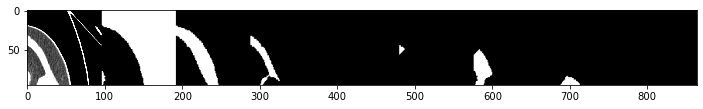

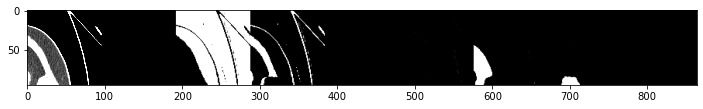

Valid


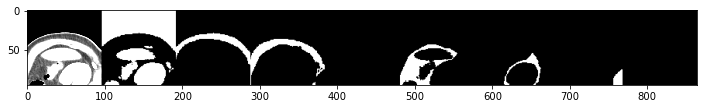

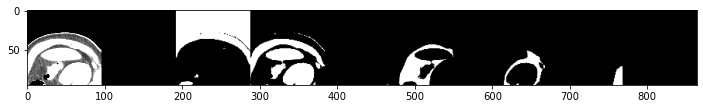

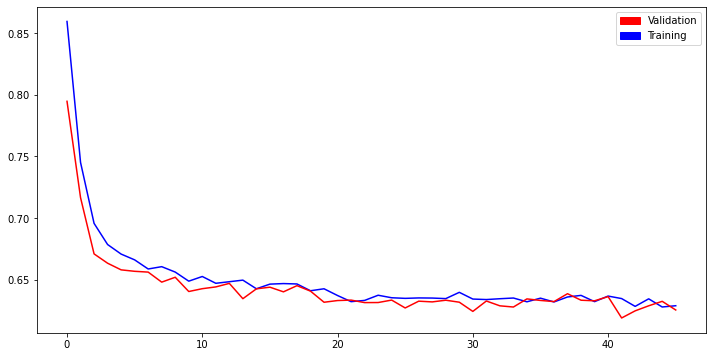

EPOCH 46 of 80
-- train loss 0.6330485062466727 -- valid loss 0.631792978328817 --
-----run time 52836.80676364899sec -----
EPOCH 47 of 80
-- train loss 0.6333721929126316 -- valid loss 0.6263344507007038 --
-----run time 54005.750890016556sec -----
EPOCH 48 of 80
-- train loss 0.633560488400636 -- valid loss 0.6382613199598649 --
-----run time 55160.560901641846sec -----
EPOCH 49 of 80
-- train loss 0.6291796643424917 -- valid loss 0.6345645811627892 --
-----run time 56244.6659078598sec -----
EPOCH 50 of 80
-- train loss 0.6340046474227199 -- valid loss 0.6297853045603808 --
-----run time 57449.955754995346sec -----
Train


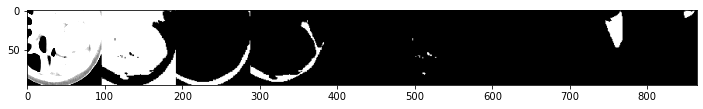

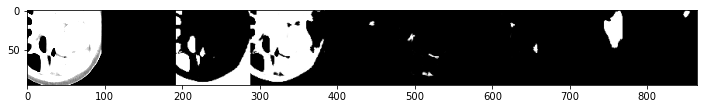

Valid


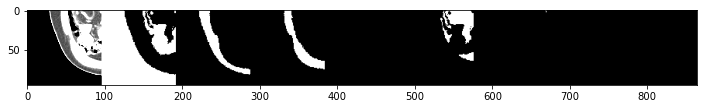

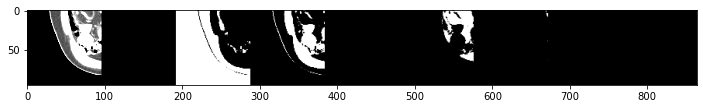

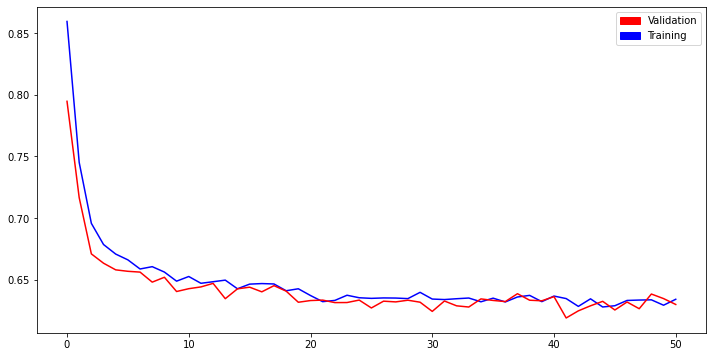

EPOCH 51 of 80
-- train loss 0.6354984605753863 -- valid loss 0.6316045908366933 --
-----run time 58581.49293065071sec -----
EPOCH 52 of 80
-- train loss 0.6369836821600243 -- valid loss 0.6329107722815346 --
-----run time 59708.58223772049sec -----
EPOCH 53 of 80
-- train loss 0.6323518577549193 -- valid loss 0.6271020388778519 --
-----run time 60791.62084674835sec -----
EPOCH 54 of 80
-- train loss 0.627242084896123 -- valid loss 0.6301254586261862 --
-----run time 61915.99264931679sec -----
EPOCH 55 of 80
-- train loss 0.6305496181602831 -- valid loss 0.6300830472918117 --
-----run time 62998.91268849373sec -----
Train


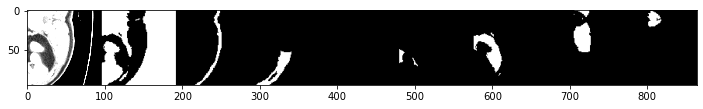

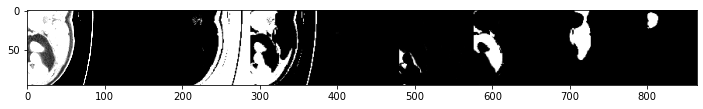

Valid


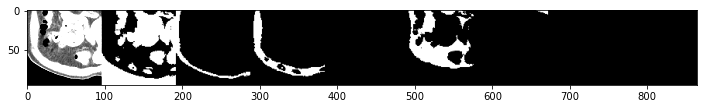

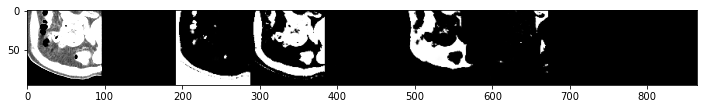

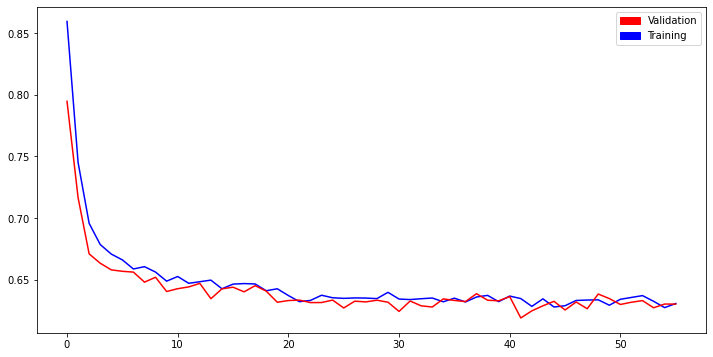

EPOCH 56 of 80
-- train loss 0.6297356122069888 -- valid loss 0.6219711557907217 --
-----run time 64207.21174144745sec -----
EPOCH 57 of 80
-- train loss 0.6348476725595968 -- valid loss 0.6371851190924644 --
-----run time 65335.90347123146sec -----
EPOCH 58 of 80
-- train loss 0.6299281986775221 -- valid loss 0.6268770352882498 --
-----run time 66416.60197973251sec -----
EPOCH 59 of 80
-- train loss 0.6343321157826318 -- valid loss 0.6364733866032433 --
-----run time 67446.73966145515sec -----
EPOCH 60 of 80
-- train loss 0.6307022287889763 -- valid loss 0.6313027476563173 --
-----run time 68575.98670983315sec -----
Train


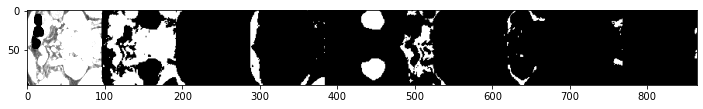

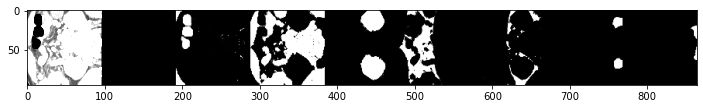

Valid


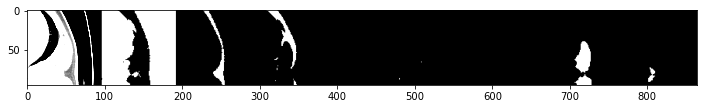

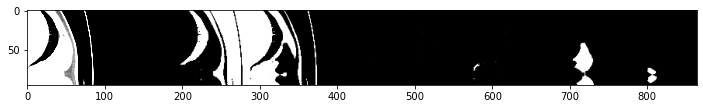

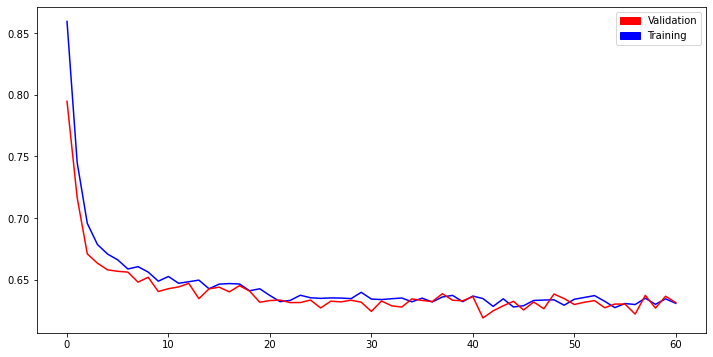

EPOCH 61 of 80
-- train loss 0.6304044164993144 -- valid loss 0.631105041679214 --
-----run time 69690.6687772274sec -----
EPOCH 62 of 80
-- train loss 0.6312318923296751 -- valid loss 0.6352923551903051 --
-----run time 70831.51139092445sec -----
EPOCH 63 of 80
-- train loss 0.6304210726861601 -- valid loss 0.6340348922154483 --
-----run time 71976.34212350845sec -----
EPOCH 64 of 80
-- train loss 0.6326357988295732 -- valid loss 0.6298422445269192 --
-----run time 73129.94531726837sec -----
EPOCH 65 of 80
-- train loss 0.6320694447667511 -- valid loss 0.6259936506257338 --
-----run time 74301.75205039978sec -----
Train


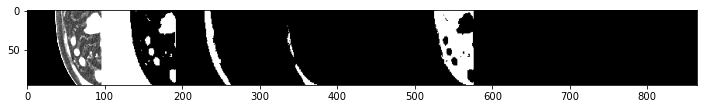

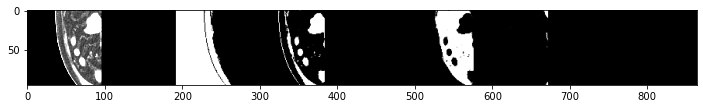

Valid


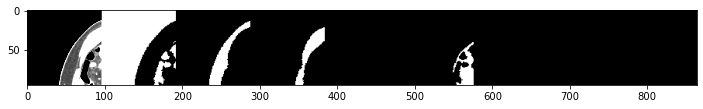

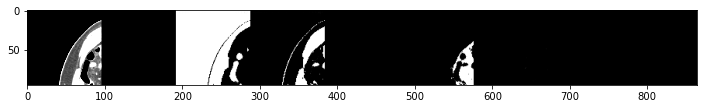

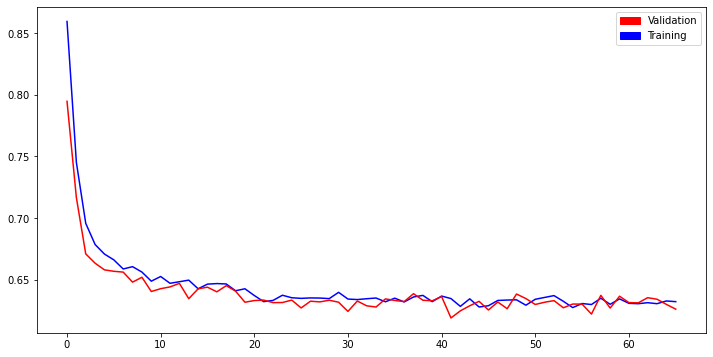

EPOCH 66 of 80
-- train loss 0.6286324594859724 -- valid loss 0.6219514231471455 --
-----run time 75351.87218761444sec -----
EPOCH 67 of 80
-- train loss 0.6324619387035016 -- valid loss 0.6285794096834519 --
-----run time 76441.28773236275sec -----
EPOCH 68 of 80
-- train loss 0.6328194983579495 -- valid loss 0.6287350900032941 --
-----run time 77552.93822836876sec -----
EPOCH 69 of 80
-- train loss 0.6326164603233337 -- valid loss 0.6263104361646316 --
-----run time 78816.98454475403sec -----
EPOCH 70 of 80
-- train loss 0.6337929512615557 -- valid loss 0.6315211373216966 --
-----run time 79994.43071913719sec -----
Train


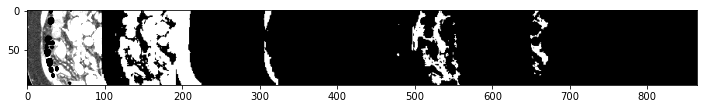

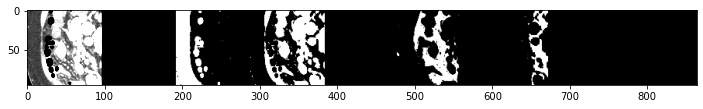

Valid


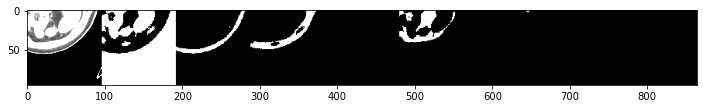

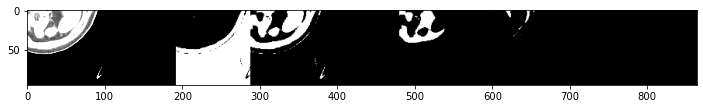

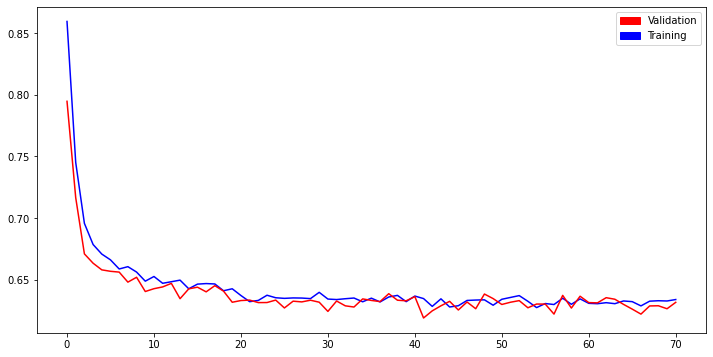

EPOCH 71 of 80
-- train loss 0.6336100303464466 -- valid loss 0.6290948557503083 --
-----run time 81080.81082510948sec -----
EPOCH 72 of 80
-- train loss 0.6324816702692597 -- valid loss 0.6265482810490272 --
-----run time 82318.59181642532sec -----
EPOCH 73 of 80
-- train loss 0.637079546628175 -- valid loss 0.6368212577174691 --
-----run time 83532.38995099068sec -----
EPOCH 74 of 80
-- train loss 0.6345159084708603 -- valid loss 0.6267309876925805 --
-----run time 84612.17751908302sec -----
EPOCH 75 of 80
-- train loss 0.6322703028166735 -- valid loss 0.6327435510123477 --
-----run time 85719.32803153992sec -----
Train


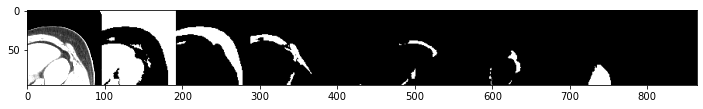

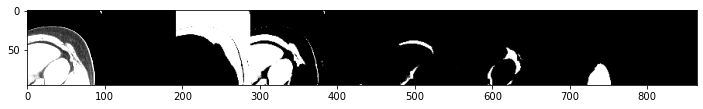

Valid


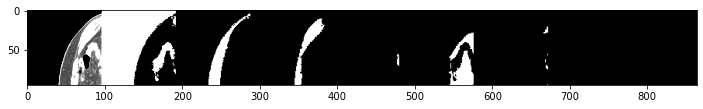

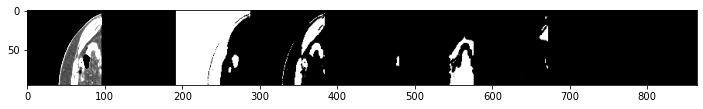

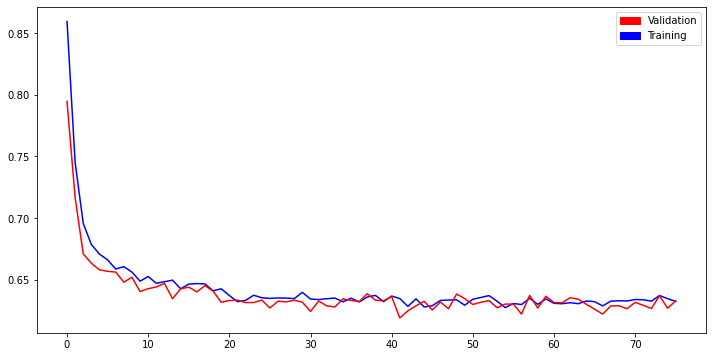

EPOCH 76 of 80
-- train loss 0.6354371977073175 -- valid loss 0.6279691931079415 --
-----run time 86830.05017971992sec -----
EPOCH 77 of 80
-- train loss 0.6327697530940727 -- valid loss 0.6405769954709446 --
-----run time 87945.79475688934sec -----
EPOCH 78 of 80
-- train loss 0.6314194875734823 -- valid loss 0.635820993605782 --
-----run time 88985.51472020149sec -----
EPOCH 79 of 80
-- train loss 0.6366137033259427 -- valid loss 0.6383424199679318 --
-----run time 90008.29583501816sec -----


In [20]:
#23.02.17 (2.1)_ Scheduler_gamma=0.1
train_losses = []
validation_losses = []
S = 50
save_path = '/home/minyoung/SEGMENTATION/23.02.16/23.02.17(2.1)'
start_time = time.time()


print('STARTING TRAINING')

for i in range(num_epochs):
    train_loss, train_seg_part, train_img_part, train_input_lbl = run_training(net_seg)
    valid_loss, valid_output_seg_part, valid_input_img_part, valid_input_lbl_part, valid_total_seg, valid_total_img = run_validation(net_seg)
    print('EPOCH {} of {}'.format(i, num_epochs))
    print('-- train loss {} -- valid loss {} --'.format(train_loss, valid_loss))
    print('-----run time {}sec -----'.format(time.time()-start_time))
    train_losses.append(train_loss)
    validation_losses.append(valid_loss)
    
        
    if i%5==0:
        
        print('Train')
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S],
                                              train_input_lbl[1,:,:,S],train_input_lbl[2,:,:,S],
                                              train_input_lbl[3,:,:,S],train_input_lbl[4,:,:,S],train_input_lbl[5,:,:,S],
                                             train_input_lbl[6,:,:,S],train_input_lbl[7,:,:,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.show()
        
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S],
                                              train_seg_part[1,:,:,S],train_seg_part[2,:,:,S],
                                              train_seg_part[3,:,:,S],train_seg_part[4,:,:,S],train_seg_part[5,:,:,S],
                                             train_seg_part[6,:,:,S],train_seg_part[7,:,:,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.show()
        
        print('Valid')
        plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S],
                                              valid_input_lbl_part[1,:,:,S],valid_input_lbl_part[2,:,:,S],
                                              valid_input_lbl_part[3,:,:,S],valid_input_lbl_part[4,:,:,S],valid_input_lbl_part[5,:,:,S],
                                             valid_input_lbl_part[6,:,:,S],valid_input_lbl_part[7,:,:,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.show()  
        plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S],
                                              valid_output_seg_part[1,:,:,S],valid_output_seg_part[2,:,:,S],
                                              valid_output_seg_part[3,:,:,S],valid_output_seg_part[4,:,:,S],valid_output_seg_part[5,:,:,S],
                                             valid_output_seg_part[6,:,:,S],valid_output_seg_part[7,:,:,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        
        plt.show()
        
        plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
        red_patch = mpatches.Patch(color='red', label='Validation')
        blue_patch = mpatches.Patch(color='blue', label='Training')
        plt.legend(handles=[red_patch, blue_patch])
        plt.show()
        
        #torch.save(net_seg,'vnet_ct_training_epoch='+str(i))
    path = os.path.join(save_path, 'vnet_ct_training_epoch='+str(i))
    torch.save(net_seg,path)
    scheduler.step()

# Test

In [26]:
# Test dataset - SubjectDataset
#import natsort
#import nibabel as nib
image_paths=[]
label_paths=[]

images_dir = '/home/minyoung/SEGMENTATION/23.02.04/Test/images'
labels_dir = '/home/minyoung/SEGMENTATION/23.02.04/Test/RE_labels'

img_list = natsort.natsorted(os.listdir(images_dir))
lb_list = natsort.natsorted(os.listdir(labels_dir))

num = len(img_list)

for i in range(0, num):
    image_paths.append(os.path.join(images_dir, img_list[i]))
    label_paths.append(os.path.join(labels_dir, lb_list[i]))
    
# image_paths = natsort.natsorted(os.listdir(images_dir))
# label_paths = natsort.natsorted(os.listdir(labels_dir))

assert len(image_paths)==len(label_paths)

subjects=[]
for (image_path, label_path) in zip(image_paths, label_paths):
#     image_path = images_dir+'/'+image_path
#     label_path = labels_dir+'/'+label_path
    subject = tio.Subject(
                img = tio.ScalarImage(image_path),
                label = tio.LabelMap(label_path))
    subjects.append(subject)
test_dataset=tio.SubjectsDataset(subjects)
print('Dataset size : ', len(test_dataset), 'subjects')

Dataset size :  20 subjects


In [30]:
# model load
model=torch.load('/home/minyoung/SEGMENTATION/23.02.16/23.02.17(2)/vnet_ct_training_epoch=79')

In [27]:
# test data transform
test_transform = tio.Compose([
    tio.Resample(1.5),
    tio.Crop((10,10,50,30,10,10)),
    tio.Clamp(-300,500),
    tio.ZNormalization(),
    tio.OneHot(),
])

test_set = tio.SubjectsDataset(
    test_dataset, transform=test_transform)

(1, 239, 179, 296) (1, 239, 179, 296) (1, 239, 179, 296)
(239, 179, 296, 1) (239, 179, 296, 1) (239, 179, 296, 1)


<Figure size 864x432 with 0 Axes>

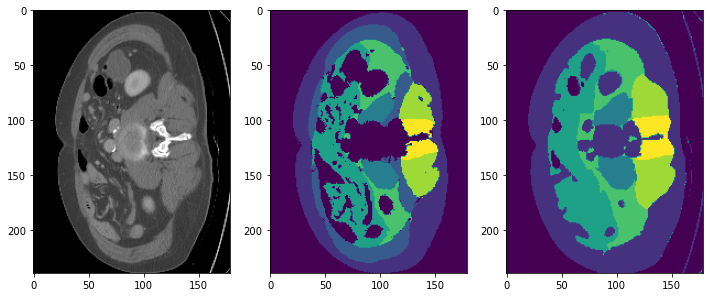

<Figure size 864x432 with 0 Axes>

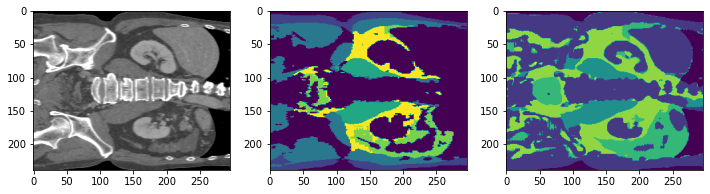

In [32]:
import nibabel as nib
A=0
device=torch.device('cuda')

# patch to 1 volume image
subject = test_set[A]
patch_size = 96  
patch_overlap = 4, 4, 4
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=1)
aggregator = tio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['img'][tio.DATA].to(device)
        locations = patches_batch[tio.LOCATION]
        probabilities = model(inputs).softmax(dim=1)
        aggregator.add_batch(probabilities, locations)

foreground = aggregator.get_output_tensor()
foreground_cat = np.argmax(foreground, axis=0)
#foreground_fix = fix_class(foreground_cat)
foreground_fix=foreground_cat[np.newaxis,:,:,:]
affine = subject['img'].affine
prediction = tio.ScalarImage(tensor=foreground_fix, affine=affine)
subject.add_image(prediction, 'prediction')
#subject.plot(figsize=(9, 8))

####################################################

# Save to nifti file
prediction = subject['prediction'].data
CTimg = subject['img'].data
label = subject['label'].data
# onehot > one image
label_arg = np.argmax(label, axis=0)
label_arg=label_arg[np.newaxis,:,:,:]

# label[label==7]=2
# label[label==8]=2
#label[label==6]=1
# label[label==5]=4

save_path = '/home/minyoung/SEGMENTATION/23.02.16/test/(2)'

prediction = prediction.numpy().astype(np.float64)
CTimg = CTimg.numpy().astype(np.float64)
label_arg = label_arg.numpy().astype(np.float64)

print(prediction.shape, CTimg.shape, label_arg.shape)
#input_seg = np.reshape(train_input_lbl,(1,256,256,120))

prediction = np.transpose(prediction,[1,2,3,0])
CTimg = np.transpose(CTimg,[1,2,3,0])
label_arg = np.transpose(label_arg,[1,2,3,0])

print(prediction.shape, CTimg.shape, label_arg.shape)

prediction_save = nib.Nifti1Image(prediction, affine=subject['prediction'].affine)
CTimg_save = nib.Nifti1Image(CTimg, affine=subject['img'].affine)
label_save = nib.Nifti1Image(label_arg, affine=subject['label'].affine)
#new_seg.header['pixdim']=[1., 2,2,3,1.,1.,1.,1.]
nib.save(prediction_save,os.path.join(save_path,'prediction_'+str(A)+'.nii.gz'))
nib.save(CTimg_save,os.path.join(save_path,'origin_'+str(A)+'.nii.gz'))
nib.save(label_save,os.path.join(save_path,'label_'+str(A)+'.nii.gz'))

######################################################

# Plot
Z=150; Y=100
plt.figure()
f, arr = plt.subplots(1,3)
arr[0].imshow(CTimg[:,:,Z,0], cmap='gray')
arr[1].imshow(label_arg[:,:,Z,0])
arr[2].imshow(prediction[:,:,Z,0])

plt.figure()
f2, arr2 = plt.subplots(1,3)
arr2[0].imshow(CTimg[:,Y,:,0], cmap='gray')
arr2[1].imshow(label_arg[:,Y,:,0])
arr2[2].imshow(prediction[:,Y,:,0])

(1, 300, 240, 282) (1, 300, 240, 282) (1, 300, 240, 282)
(300, 240, 282, 1) (300, 240, 282, 1) (300, 240, 282, 1)


<Figure size 864x432 with 0 Axes>

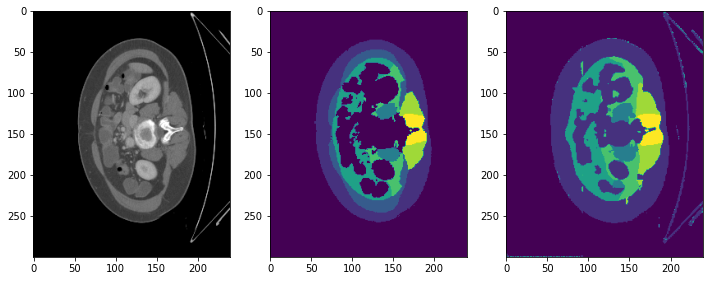

<Figure size 864x432 with 0 Axes>

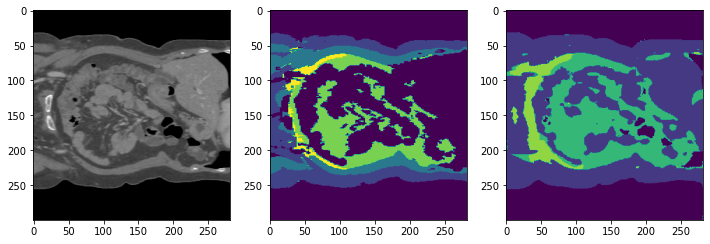

In [33]:
A=10
device=torch.device('cuda')

# patch to 1 volume image
subject = test_set[A]
patch_size = 96  
patch_overlap = 4, 4, 4
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=1)
aggregator = tio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['img'][tio.DATA].to(device)
        locations = patches_batch[tio.LOCATION]
        probabilities = model(inputs).softmax(dim=1)
        aggregator.add_batch(probabilities, locations)

foreground = aggregator.get_output_tensor()
foreground_cat = np.argmax(foreground, axis=0)
#foreground_fix = fix_class(foreground_cat)
foreground_fix=foreground_cat[np.newaxis,:,:,:]
affine = subject['img'].affine
prediction = tio.ScalarImage(tensor=foreground_fix, affine=affine)
subject.add_image(prediction, 'prediction')
#subject.plot(figsize=(9, 8))

####################################################

# Save to nifti file
prediction = subject['prediction'].data
CTimg = subject['img'].data
label = subject['label'].data
# onehot > one image
label_arg = np.argmax(label, axis=0)
label_arg=label_arg[np.newaxis,:,:,:]

# label[label==7]=2
# label[label==8]=2
#label[label==6]=1
# label[label==5]=4

save_path = '/home/minyoung/SEGMENTATION/23.02.16/test/(2)'

prediction = prediction.numpy().astype(np.float64)
CTimg = CTimg.numpy().astype(np.float64)
label_arg = label_arg.numpy().astype(np.float64)

print(prediction.shape, CTimg.shape, label_arg.shape)
#input_seg = np.reshape(train_input_lbl,(1,256,256,120))

prediction = np.transpose(prediction,[1,2,3,0])
CTimg = np.transpose(CTimg,[1,2,3,0])
label_arg = np.transpose(label_arg,[1,2,3,0])

print(prediction.shape, CTimg.shape, label_arg.shape)

prediction_save = nib.Nifti1Image(prediction, affine=subject['prediction'].affine)
CTimg_save = nib.Nifti1Image(CTimg, affine=subject['img'].affine)
label_save = nib.Nifti1Image(label_arg, affine=subject['label'].affine)
#new_seg.header['pixdim']=[1., 2,2,3,1.,1.,1.,1.]
nib.save(prediction_save,os.path.join(save_path,'prediction_'+str(A)+'.nii.gz'))
nib.save(CTimg_save,os.path.join(save_path,'origin_'+str(A)+'.nii.gz'))
nib.save(label_save,os.path.join(save_path,'label_'+str(A)+'.nii.gz'))

######################################################

# Plot
Z=150; Y=100
plt.figure()
f, arr = plt.subplots(1,3)
arr[0].imshow(CTimg[:,:,Z,0], cmap='gray')
arr[1].imshow(label_arg[:,:,Z,0])
arr[2].imshow(prediction[:,:,Z,0])

plt.figure()
f2, arr2 = plt.subplots(1,3)
arr2[0].imshow(CTimg[:,Y,:,0], cmap='gray')
arr2[1].imshow(label_arg[:,Y,:,0])
arr2[2].imshow(prediction[:,Y,:,0])

In [27]:
label = subject['label'].data
print(label.shape)

torch.Size([8, 239, 179, 296])


torch.Size([239, 179, 296])


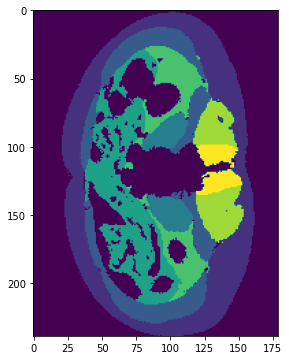

In [29]:
#foreground_cat = np.argmax(foreground, axis=0)
label_argmax = np.argmax(label, axis=0)
print(label_argmax.shape)
plt.imshow(label_argmax[:,:,150])
plt.show()

In [34]:
label.shape

torch.Size([8, 300, 240, 282])

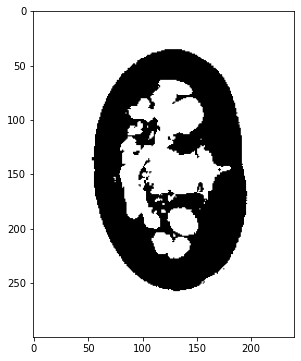

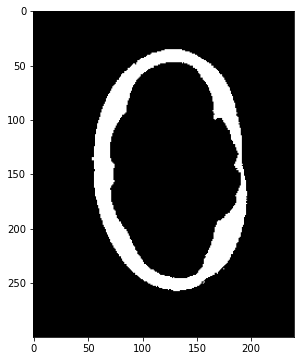

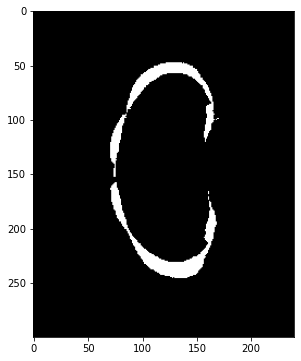

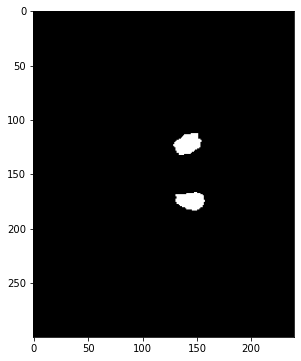

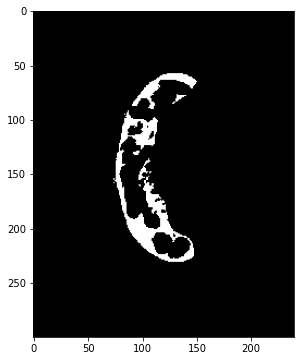

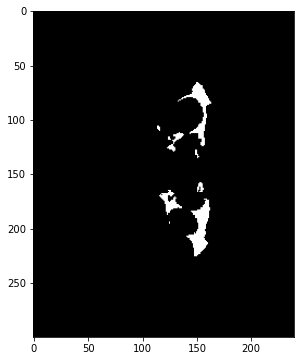

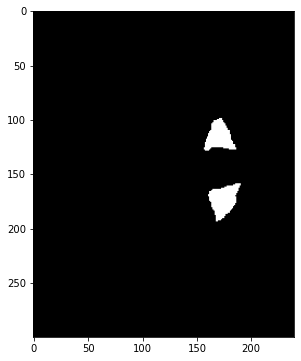

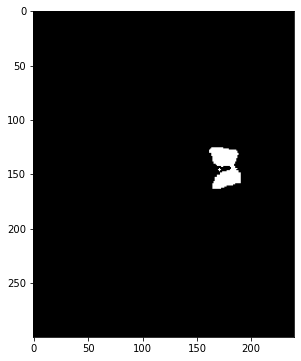

In [35]:
for i in range(label.shape[0]):
    plt.imshow(label[i,:,:,150], cmap='gray')
    plt.show()

### TEST (2.1)

In [22]:
# model load
model=torch.load('/home/minyoung/SEGMENTATION/23.02.16/23.02.17(2.1)/vnet_ct_training_epoch=79')

In [24]:
# test data transform
test_transform = tio.Compose([
    tio.Resample(1.5),
    tio.Crop((10,10,50,30,10,10)),
    tio.Clamp(-300,500),
    tio.ZNormalization(),
    tio.OneHot(),
])

test_set = tio.SubjectsDataset(
    test_dataset, transform=test_transform)

NameError: name 'test_dataset' is not defined

(1, 300, 240, 282) (1, 300, 240, 282) (1, 300, 240, 282)
(300, 240, 282, 1) (300, 240, 282, 1) (300, 240, 282, 1)


<Figure size 864x432 with 0 Axes>

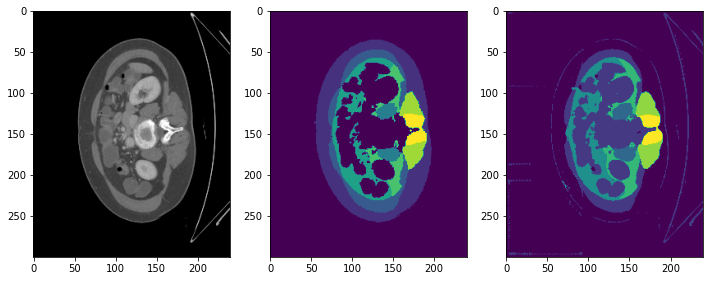

<Figure size 864x432 with 0 Axes>

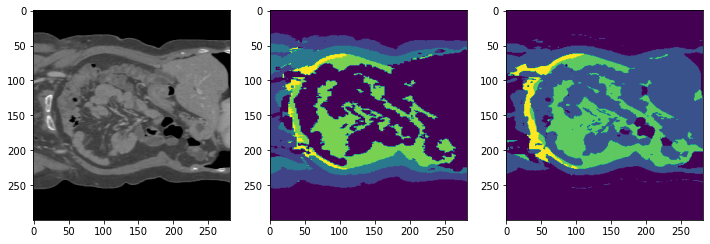

In [24]:
import nibabel as nib
A=10
device=torch.device('cuda')

# patch to 1 volume image
subject = test_set[A]
patch_size = 96  
patch_overlap = 4, 4, 4
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=1)
aggregator = tio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['img'][tio.DATA].to(device)
        locations = patches_batch[tio.LOCATION]
        probabilities = model(inputs).softmax(dim=1)
        aggregator.add_batch(probabilities, locations)

foreground = aggregator.get_output_tensor()
foreground_cat = np.argmax(foreground, axis=0)
#foreground_fix = fix_class(foreground_cat)
foreground_fix=foreground_cat[np.newaxis,:,:,:]
affine = subject['img'].affine
prediction = tio.ScalarImage(tensor=foreground_fix, affine=affine)
subject.add_image(prediction, 'prediction')
#subject.plot(figsize=(9, 8))

####################################################

# Save to nifti file
prediction = subject['prediction'].data
CTimg = subject['img'].data
label = subject['label'].data
# onehot > one image
label_arg = np.argmax(label, axis=0)
label_arg=label_arg[np.newaxis,:,:,:]

# label[label==7]=2
# label[label==8]=2
#label[label==6]=1
# label[label==5]=4

save_path = '/home/minyoung/SEGMENTATION/23.02.16/test/(2.1)'

prediction = prediction.numpy().astype(np.float64)
CTimg = CTimg.numpy().astype(np.float64)
label_arg = label_arg.numpy().astype(np.float64)

print(prediction.shape, CTimg.shape, label_arg.shape)
#input_seg = np.reshape(train_input_lbl,(1,256,256,120))

prediction = np.transpose(prediction,[1,2,3,0])
CTimg = np.transpose(CTimg,[1,2,3,0])
label_arg = np.transpose(label_arg,[1,2,3,0])

print(prediction.shape, CTimg.shape, label_arg.shape)

prediction_save = nib.Nifti1Image(prediction, affine=subject['prediction'].affine)
CTimg_save = nib.Nifti1Image(CTimg, affine=subject['img'].affine)
label_save = nib.Nifti1Image(label_arg, affine=subject['label'].affine)
#new_seg.header['pixdim']=[1., 2,2,3,1.,1.,1.,1.]
nib.save(prediction_save,os.path.join(save_path,'prediction_'+str(A)+'.nii.gz'))
nib.save(CTimg_save,os.path.join(save_path,'origin_'+str(A)+'.nii.gz'))
nib.save(label_save,os.path.join(save_path,'label_'+str(A)+'.nii.gz'))

######################################################

# Plot
Z=150; Y=100
plt.figure()
f, arr = plt.subplots(1,3)
arr[0].imshow(CTimg[:,:,Z,0], cmap='gray')
arr[1].imshow(label_arg[:,:,Z,0])
arr[2].imshow(prediction[:,:,Z,0])

plt.figure()
f2, arr2 = plt.subplots(1,3)
arr2[0].imshow(CTimg[:,Y,:,0], cmap='gray')
arr2[1].imshow(label_arg[:,Y,:,0])
arr2[2].imshow(prediction[:,Y,:,0])

<Figure size 864x432 with 0 Axes>

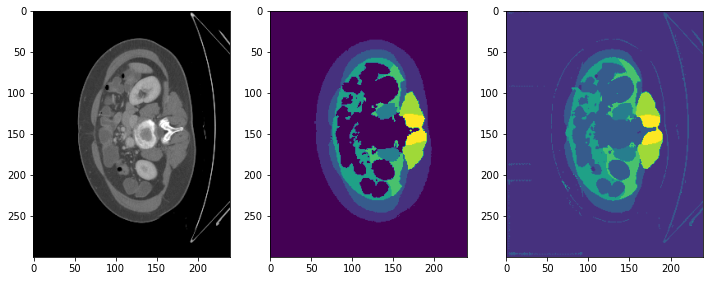

<Figure size 864x432 with 0 Axes>

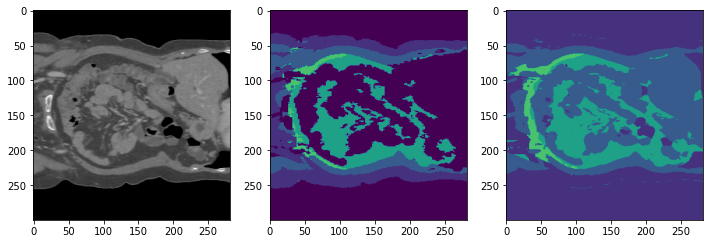

In [26]:
# Plot
Z=150; Y=100
plt.figure()
f, arr = plt.subplots(1,3)
arr[0].imshow(CTimg[:,:,Z,0], cmap='gray')
arr[1].imshow(label_arg[:,:,Z,0],vmin=0,vmax=7 )
arr[2].imshow(prediction[:,:,Z,0],vmin=0,vmax=7)

plt.figure()
f2, arr2 = plt.subplots(1,3)
arr2[0].imshow(CTimg[:,Y,:,0], cmap='gray')
arr2[1].imshow(label_arg[:,Y,:,0],vmin=0,vmax=7)
arr2[2].imshow(prediction[:,Y,:,0],vmin=0,vmax=7)

## 2.1.1 Test

In [23]:
# model load
model=torch.load('/home/minyoung/SEGMENTATION/23.02.22/model_backup/02.24(2.1.1)/vnet_epoch=79')

(1, 300, 240, 282) (1, 300, 240, 282) (1, 300, 240, 282)
(300, 240, 282, 1) (300, 240, 282, 1) (300, 240, 282, 1)


<Figure size 864x432 with 0 Axes>

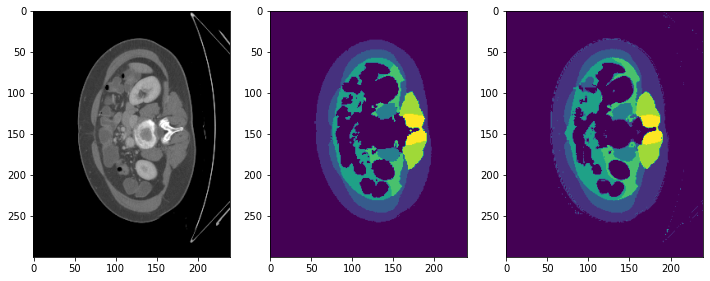

<Figure size 864x432 with 0 Axes>

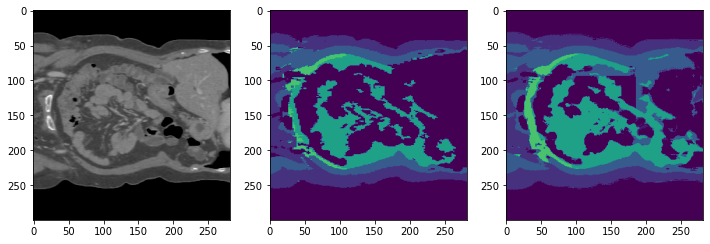

In [28]:
import nibabel as nib
A=10
device=torch.device('cuda')

# patch to 1 volume image
subject = test_set[A]
patch_size = 96  
patch_overlap = 4, 4, 4
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=1)
aggregator = tio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['img'][tio.DATA].to(device)
        locations = patches_batch[tio.LOCATION]
        probabilities = model(inputs).softmax(dim=1)
        aggregator.add_batch(probabilities, locations)

foreground = aggregator.get_output_tensor()
foreground_cat = np.argmax(foreground, axis=0)
#foreground_fix = fix_class(foreground_cat)
foreground_fix=foreground_cat[np.newaxis,:,:,:]
affine = subject['img'].affine
prediction = tio.ScalarImage(tensor=foreground_fix, affine=affine)
subject.add_image(prediction, 'prediction')
#subject.plot(figsize=(9, 8))

####################################################

# Save to nifti file
prediction = subject['prediction'].data
CTimg = subject['img'].data
label = subject['label'].data
# onehot > one image
label_arg = np.argmax(label, axis=0)
label_arg=label_arg[np.newaxis,:,:,:]

# label[label==7]=2
# label[label==8]=2
#label[label==6]=1
# label[label==5]=4

save_path = '/home/minyoung/SEGMENTATION/23.02.22/test/(2.1.1)'

prediction = prediction.numpy().astype(np.float64)
CTimg = CTimg.numpy().astype(np.float64)
label_arg = label_arg.numpy().astype(np.float64)

print(prediction.shape, CTimg.shape, label_arg.shape)
#input_seg = np.reshape(train_input_lbl,(1,256,256,120))

prediction = np.transpose(prediction,[1,2,3,0])
CTimg = np.transpose(CTimg,[1,2,3,0])
label_arg = np.transpose(label_arg,[1,2,3,0])

print(prediction.shape, CTimg.shape, label_arg.shape)

prediction_save = nib.Nifti1Image(prediction, affine=subject['prediction'].affine)
CTimg_save = nib.Nifti1Image(CTimg, affine=subject['img'].affine)
label_save = nib.Nifti1Image(label_arg, affine=subject['label'].affine)
#new_seg.header['pixdim']=[1., 2,2,3,1.,1.,1.,1.]
nib.save(prediction_save,os.path.join(save_path,'prediction_'+str(A)+'.nii.gz'))
nib.save(CTimg_save,os.path.join(save_path,'origin_'+str(A)+'.nii.gz'))
nib.save(label_save,os.path.join(save_path,'label_'+str(A)+'.nii.gz'))

######################################################

# Plot
Z=150; Y=100
plt.figure()
f, arr = plt.subplots(1,3)
arr[0].imshow(CTimg[:,:,Z,0], cmap='gray')
arr[1].imshow(label_arg[:,:,Z,0],vmin=0,vmax=7)
arr[2].imshow(prediction[:,:,Z,0],vmin=0,vmax=7)

plt.figure()
f2, arr2 = plt.subplots(1,3)
arr2[0].imshow(CTimg[:,Y,:,0], cmap='gray')
arr2[1].imshow(label_arg[:,Y,:,0],vmin=0,vmax=7)
arr2[2].imshow(prediction[:,Y,:,0],vmin=0,vmax=7)

(1, 239, 179, 296) (1, 239, 179, 296) (1, 239, 179, 296)
(239, 179, 296, 1) (239, 179, 296, 1) (239, 179, 296, 1)


<Figure size 864x432 with 0 Axes>

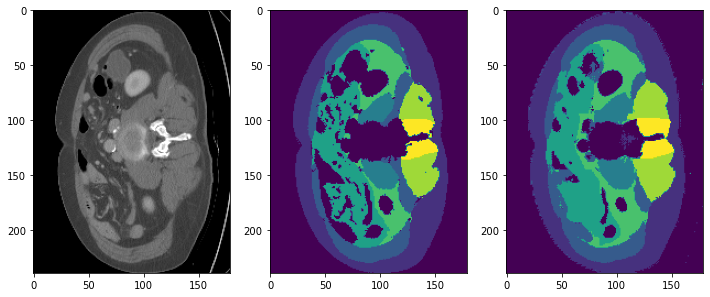

<Figure size 864x432 with 0 Axes>

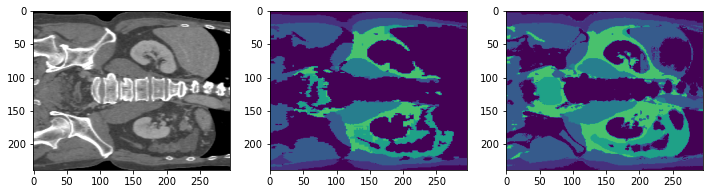

In [29]:
#import nibabel as nib
A=0
device=torch.device('cuda')

# patch to 1 volume image
subject = test_set[A]
patch_size = 96  
patch_overlap = 4, 4, 4
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=1)
aggregator = tio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['img'][tio.DATA].to(device)
        locations = patches_batch[tio.LOCATION]
        probabilities = model(inputs).softmax(dim=1)
        aggregator.add_batch(probabilities, locations)

foreground = aggregator.get_output_tensor()
foreground_cat = np.argmax(foreground, axis=0)
#foreground_fix = fix_class(foreground_cat)
foreground_fix=foreground_cat[np.newaxis,:,:,:]
affine = subject['img'].affine
prediction = tio.ScalarImage(tensor=foreground_fix, affine=affine)
subject.add_image(prediction, 'prediction')
#subject.plot(figsize=(9, 8))

####################################################

# Save to nifti file
prediction = subject['prediction'].data
CTimg = subject['img'].data
label = subject['label'].data
# onehot > one image
label_arg = np.argmax(label, axis=0)
label_arg=label_arg[np.newaxis,:,:,:]

# label[label==7]=2
# label[label==8]=2
#label[label==6]=1
# label[label==5]=4

save_path = '/home/minyoung/SEGMENTATION/23.02.22/test/(2.1.1)'

prediction = prediction.numpy().astype(np.float64)
CTimg = CTimg.numpy().astype(np.float64)
label_arg = label_arg.numpy().astype(np.float64)

print(prediction.shape, CTimg.shape, label_arg.shape)
#input_seg = np.reshape(train_input_lbl,(1,256,256,120))

prediction = np.transpose(prediction,[1,2,3,0])
CTimg = np.transpose(CTimg,[1,2,3,0])
label_arg = np.transpose(label_arg,[1,2,3,0])

print(prediction.shape, CTimg.shape, label_arg.shape)

prediction_save = nib.Nifti1Image(prediction, affine=subject['prediction'].affine)
CTimg_save = nib.Nifti1Image(CTimg, affine=subject['img'].affine)
label_save = nib.Nifti1Image(label_arg, affine=subject['label'].affine)
#new_seg.header['pixdim']=[1., 2,2,3,1.,1.,1.,1.]
nib.save(prediction_save,os.path.join(save_path,'prediction_'+str(A)+'.nii.gz'))
nib.save(CTimg_save,os.path.join(save_path,'origin_'+str(A)+'.nii.gz'))
nib.save(label_save,os.path.join(save_path,'label_'+str(A)+'.nii.gz'))

######################################################

# Plot
Z=150; Y=100
plt.figure()
f, arr = plt.subplots(1,3)
arr[0].imshow(CTimg[:,:,Z,0], cmap='gray')
arr[1].imshow(label_arg[:,:,Z,0],vmin=0,vmax=7)
arr[2].imshow(prediction[:,:,Z,0],vmin=0,vmax=7)

plt.figure()
f2, arr2 = plt.subplots(1,3)
arr2[0].imshow(CTimg[:,Y,:,0], cmap='gray')
arr2[1].imshow(label_arg[:,Y,:,0],vmin=0,vmax=7)
arr2[2].imshow(prediction[:,Y,:,0],vmin=0,vmax=7)